In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!nvidia-smi

Sat Aug 28 15:34:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install --quiet transformers
!pip install --quiet pytorch-lightning

     |████████████████████████████████| 2.6 MB 7.1 MB/s 
     |████████████████████████████████| 3.3 MB 57.8 MB/s 
     |████████████████████████████████| 895 kB 65.7 MB/s 
     |████████████████████████████████| 636 kB 72.4 MB/s 
     |████████████████████████████████| 918 kB 7.9 MB/s 
     |████████████████████████████████| 272 kB 71.5 MB/s 
     |████████████████████████████████| 829 kB 57.2 MB/s 
     |████████████████████████████████| 118 kB 64.4 MB/s 
     |████████████████████████████████| 1.3 MB 72.7 MB/s 
     |████████████████████████████████| 294 kB 76.6 MB/s 
     |████████████████████████████████| 142 kB 66.5 MB/s 


In [ ]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline  
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

from collections import Counter

Global seed set to 42


In [ ]:
# import dataset
train_df = pd.read_csv('drive/MyDrive/Biocreative/Biocreative/datasets/TRAIN.csv')
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.head(), train_df.shape

(       pmid  ...                                     Title&Keywords
 0  32265202  ...  Ocular manifestation hospitalised patient conf...
 1  33036702  ...  COVID-19 senior Findings lesson mass screening...
 2  32406522  ...  COVID-19 Focus lung forget gastrointestinal tr...
 3  32599534  ...  subcutaneous insulin administration adequate m...
 4  33005463  ...  First Case COVID-19-Associated Collapsing Glom...
 
 [5 rows x 13 columns], (30738, 13))

In [ ]:
LABEL_COLUMNS = train_df.columns.tolist()[5:-1]

In [ ]:
print(LABEL_COLUMNS)

['Case Report', 'Diagnosis', 'Epidemic Forecasting', 'Mechanism', 'Prevention', 'Transmission', 'Treatment']


In [ ]:
# BERT_MODEL_NAME = 'dmis-lab/biobert-base-cased-v1.1'
# Ref : microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
# Ref 2.0 : lordtt13/COVID-SciBERT
BERT_MODEL_NAME = input("Enter Bert Model Name: ")
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

Enter Bert Model Name: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext


Downloading:   0%|          | 0.00/337 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [ ]:
train_df[LABEL_COLUMNS].sum().sort_values()

Epidemic Forecasting     1528
Case Report              2291
Transmission             3165
Mechanism                5414
Diagnosis                7456
Treatment               10091
Prevention              13998
dtype: int64

In [ ]:
MAX_TOKEN_COUNT = 512

In [ ]:
class TopicAnnotationDataset(Dataset):

  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: AutoTokenizer,
    max_token_len: int = 512,
    title_max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    self.title_max_token_len = title_max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index=int):
    
    data_row = self.data.iloc[index]

    abstract_text = data_row.abstract
    labels = data_row[LABEL_COLUMNS]

    title_text = data_row.title

    encoding = self.tokenizer.encode_plus(
        abstract_text,
        add_special_tokens=True,
        max_length=self.max_token_len,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    title_encoding = self.tokenizer.encode_plus(
        title_text,
        add_special_tokens=True,
        max_length=self.title_max_token_len,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    return dict(
        abstract_text=abstract_text,
        title_text=title_text,
        input_ids=encoding["input_ids"].flatten(),
        attention_mask=encoding["attention_mask"].flatten(),
        title_input_ids=title_encoding["input_ids"].flatten(),
        title_attention_mask=title_encoding["attention_mask"].flatten(),
        labels=torch.FloatTensor(labels) 
    )  

In [ ]:
train_dataset = TopicAnnotationDataset(
    train_df,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
class TopicAnnotationDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    
    self.train_dataset =  TopicAnnotationDataset(
        self.train_df,
        self.tokenizer,
        self.max_token_len
    )

    self.test_dataset = TopicAnnotationDataset(
        self.test_df,
        self.tokenizer,
        self.max_token_len
    )

  def train_dataloader(self):

    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):

    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [ ]:
  %pwd

'/content'

In [ ]:
val_df = pd.read_csv("/content/drive/MyDrive/Biocreative/Biocreative/datasets/VAL.csv")
val_df = val_df.sample(frac=1).reset_index(drop=True)
val_df.shape

(3423, 13)

In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 8

data_module = TopicAnnotationDataModule(
    train_df,
    val_df,
    tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
Label_count = train_df[LABEL_COLUMNS].sum().to_dict()
count = list(Label_count.values())
max_val = max(count)
class_weight = [max_val/val for val in count]
print(class_weight)

[6.109995635093846, 1.8774141630901287, 9.160994764397905, 2.5855190247506465, 1.0, 4.4227488151658765, 1.3871766921018729]


In [ ]:
# print label and corresponding weights
dict(zip(LABEL_COLUMNS, class_weight))

{'Case Report': 6.109995635093846,
 'Diagnosis': 1.8774141630901287,
 'Epidemic Forecasting': 9.160994764397905,
 'Mechanism': 2.5855190247506465,
 'Prevention': 1.0,
 'Transmission': 4.4227488151658765,
 'Treatment': 1.3871766921018729}

In [ ]:
class_weight = torch.tensor(class_weight, device="cuda")

In [ ]:
class FFN(nn.Module):
  def __init__(self, in_feat, out_feat, dropout):
      super(FFN, self).__init__()
      self.in2hid = nn.Linear(in_feat, in_feat)
      self.hid2out = nn.Linear(in_feat, out_feat)

      self.activation = nn.ReLU()
      self.dropout = nn.Dropout(dropout)

  def forward(self, input):
      hid = self.activation(self.dropout(self.in2hid(input)))
      return self.hid2out(hid)

In [ ]:
class TopicAnnotationTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None, ffn_dim: int = 512, out_feat: int = 768, dropout=0.2):
    
    super().__init__()
    self.bert = AutoModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.bert_title = AutoModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    # self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss(weight=class_weight)
    self.sigmoid = nn.Sigmoid()

    # angry-bert layers
    self.ffn_dim = ffn_dim
    self.out_feat = out_feat
    self.dropout = nn.Dropout(p=dropout)
    self.activation = nn.ReLU()
    
    self.gate = nn.Linear(
        (self.bert.config.hidden_size + self.bert_title.config.hidden_size), 
        self.ffn_dim
    )

    self.ffn = FFN(self.ffn_dim, out_feat, dropout=0.2)
    self.classifier = nn.Linear(self.out_feat, n_classes)

  def forward(self, input_ids, attention_mask, title_input_ids, title_attention_mask, labels=None):

    bert_outputs = self.bert(input_ids, attention_mask=attention_mask)
    # pooler_output (batch_size x hidden_size)
    encoded_output_bert = bert_outputs.pooler_output

    bert_title_outputs = self.bert(title_input_ids, attention_mask=title_attention_mask)
    # pooler_output (batch_size x hidden_size)
    encoded_output_bert_title = bert_outputs.pooler_output

    # gate-fusion
    gatein = torch.cat((encoded_output_bert, encoded_output_bert_title), dim=-1)
    chosen = self.activation(self.dropout(self.gate(gatein)))

    res = self.ffn(chosen)

    # classification
    output = self.classifier(res)
    output = torch.sigmoid(output)

    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    title_input_ids = batch["title_input_ids"]
    title_attention_mask = batch["title_attention_mask"]
    labels = batch["labels"]

    loss, outputs = self(input_ids, attention_mask, title_input_ids, title_attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    title_input_ids = batch["title_input_ids"]
    title_attention_mask = batch["title_attention_mask"]
    labels = batch["labels"]

    loss, outputs = self(input_ids, attention_mask, title_input_ids, title_attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    title_input_ids = batch["title_input_ids"]
    title_attention_mask = batch["title_attention_mask"]
    labels = batch["labels"]

    loss, outputs = self(input_ids, attention_mask, title_input_ids, title_attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):

    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)

  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
        optimizer=optimizer,
        lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
            )
        )

In [ ]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(7684, 38420)

In [ ]:
model = TopicAnnotationTagger(
    n_classes=len(LABEL_COLUMNS),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-unc

In [ ]:
%pwd

'/content'

In [ ]:
cd '/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/'

/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs


In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath="ANGRYBERT-lstm-checkpoints(-weights)",
    filename="ANGRYBERT-lstm-best-checkpoint",
    save_top_k=3,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

In [ ]:
logger = TensorBoardLogger("ANGRYBERT-lstm-lightning_logs(-weights)", name="topic-annotations")

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=True,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 109 M 
1 | bert_title | BertModel | 109 M 
2 | criterion  | BCELoss   | 0     
3 | sigmoid    | Sigmoid   | 0     
4 | dropout    | Dropout   | 0     
5 | activation | ReLU      | 0     
6 | gate       | Linear    | 786 K 
7 | ffn        | FFN       | 656 K 
8 | classifier | Linear    | 5.4 K 
-----------------------------------------
220 M     Trainable params
0         Non-trainable params
220 M     Total params
881.654   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:398: LightningDeprecationWarning: One of the returned values {'labels', 'predictions'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `auroc` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.auroc.auroc`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)
Epoch 0, global step 3842: val_loss reached 0.15115 (best 0.15115), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/ANGRYBERT-lstm-checkpoints(-weights)/ANGRYBERT-lstm-best-checkpoint.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 7685: val_loss reached 0.13989 (best 0.13989), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/ANGRYBERT-lstm-checkpoints(-weights)/ANGRYBERT-lstm-best-checkpoint-v1.ckpt" as top 3


### Test

In [ ]:
trained_model = TopicAnnotationTagger.load_from_checkpoint('/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/ANGRYBERT-lwan-checkpoints/ANGRYBERT-lwan-best-checkpoint-v1.ckpt', n_classes=7)

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-unc

In [ ]:
trained_model.freeze()

### Evaluation

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = TopicAnnotationDataset(
    val_df,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
predictions = []
labels = []

for item in tqdm(val_dataset):

  _, prediction = trained_model(
      item["input_ids"].unsqueeze(dim=0).to(device),
      item["attention_mask"].unsqueeze(dim=0).to(device),    
      item["title_input_ids"].unsqueeze(dim=0).to(device),
      item["title_attention_mask"].unsqueeze(dim=0).to(device)
  )
  
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/3423 [00:00<?, ?it/s]

#### data analysis

In [ ]:
# convert prediction in boolean labels
y_pred = (predictions > 0.65).type(torch.uint8)
y_true = labels  

In [ ]:
# count non-zero values
true_counts = y_true.count_nonzero(dim=1)
pred_counts = y_pred.count_nonzero(dim=1)

In [ ]:
# dict mapping for count -> key 
unique, counts = true_counts.unique(return_counts=True)
true_count_dict = dict(zip(unique.tolist(), counts.tolist()))
print(true_count_dict)

{1: 18927, 2: 8069, 3: 930, 4: 130, 5: 19}


In [ ]:
X = [1, 2, 3, 4, 5]
for label in X:
  try:
    val = true_count_dict[label]
  except Exception as e:
    true_count_dict[label] = 0

true_count_dict

{1: 18927, 2: 8069, 3: 930, 4: 130, 5: 19}

In [ ]:
# dict mapping for count -> key
pred_count_dict = {
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0
}

for idx, value in enumerate(true_counts):
  if value == pred_counts[idx]: 
    pred_count_dict[value.tolist()] += 1
  else:
    pass

pred_count_dict

{1: 17165, 2: 5652, 3: 380, 4: 25, 5: 2}

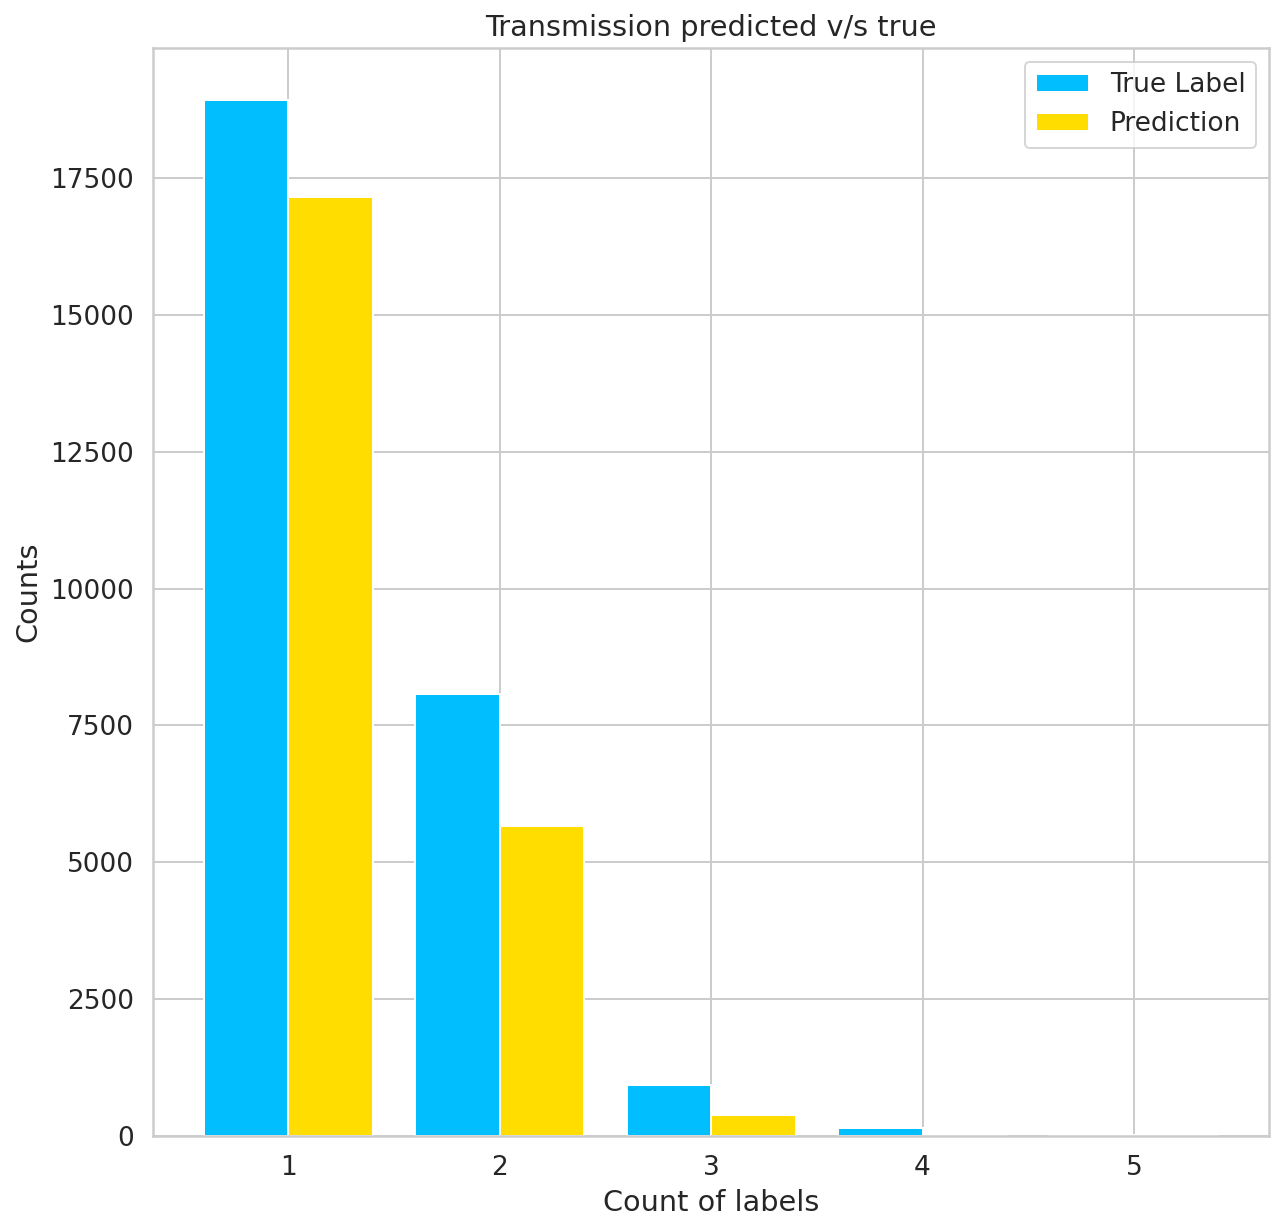

In [ ]:
X = ["1", "2", "3", "4", "5"]

# creating the dataset 
keys = list(pred_count_dict.keys()) 
pred_values = list(pred_count_dict.values()) 
true_values = list(true_count_dict.values())

keys = np.array(keys)

fig = plt.figure(figsize = (10, 10)) 
  
# creating the bar plot 
plt.bar(keys - 0.2, true_values, 0.4, label = 'True Label')
plt.bar(keys + 0.2, pred_values, 0.4, label = 'Prediction')

plt.xticks(keys, X)
plt.xlabel("Count of labels")
plt.ylabel("Counts")
plt.title("Transmission predicted v/s true")
plt.legend()
plt.show() 

In [ ]:
class_dict_pred = dict(zip(LABEL_COLUMNS, [0]*7))
class_dict_true = dict(zip(LABEL_COLUMNS, [0]*7))
class_dict_pred, class_dict_true

({'Case Report': 0,
  'Diagnosis': 0,
  'Epidemic Forecasting': 0,
  'Mechanism': 0,
  'Prevention': 0,
  'Transmission': 0,
  'Treatment': 0},
 {'Case Report': 0,
  'Diagnosis': 0,
  'Epidemic Forecasting': 0,
  'Mechanism': 0,
  'Prevention': 0,
  'Transmission': 0,
  'Treatment': 0})

In [ ]:
THRESHOLD = 0.5
print(LABEL_COLUMNS)

for item in val_dataset:

  labels = item["labels"].numpy()
  count = np.count_nonzero(labels)

  if count == 2:
    
    _, prediction = trained_model(
        item["input_ids"].unsqueeze(dim=0).to(device),
        item["attention_mask"].unsqueeze(dim=0).to(device)
    )

    # print((prediction > THRESHOLD).type(torch.uint8))

    prediction = prediction.cpu()

    for idx, key in enumerate(class_dict_pred.keys()):

      class_dict_pred[key] += (prediction[0, idx] > THRESHOLD).type(torch.uint8)

    for idx, key in enumerate(class_dict_true.keys()):
      class_dict_true[key] += labels[idx]

['Case Report', 'Diagnosis', 'Epidemic Forecasting', 'Mechanism', 'Prevention', 'Transmission', 'Treatment']


In [ ]:
for key, value in class_dict_pred.items():

  class_dict_pred[key] = value.numpy().item()

print(class_dict_pred)
print(class_dict_true)

{'Case Report': 2, 'Diagnosis': 112, 'Epidemic Forecasting': 52, 'Mechanism': 45, 'Prevention': 18, 'Transmission': 3, 'Treatment': 21}
{'Case Report': 0.0, 'Diagnosis': 119.0, 'Epidemic Forecasting': 19.0, 'Mechanism': 129.0, 'Prevention': 482.0, 'Transmission': 755.0, 'Treatment': 6.0}


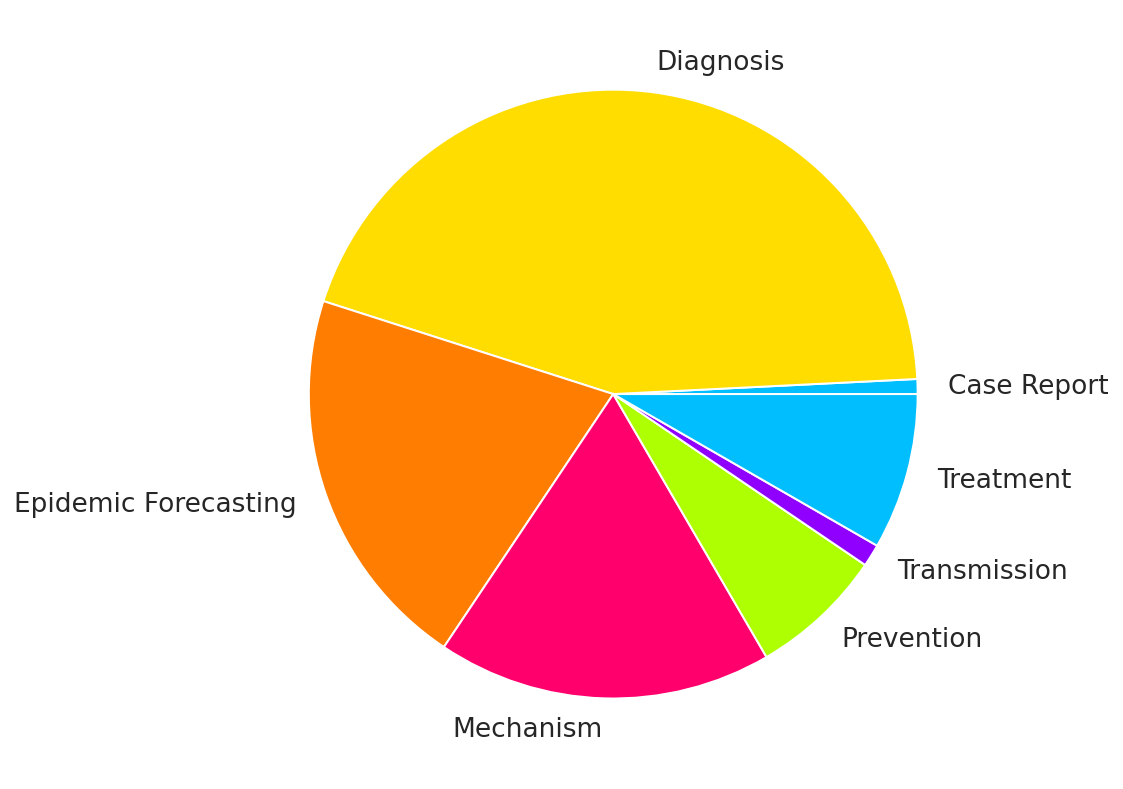

In [ ]:
keys = class_dict_pred.keys()
values = class_dict_pred.values()

# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(values, labels = keys)
  
# show plot
plt.show()

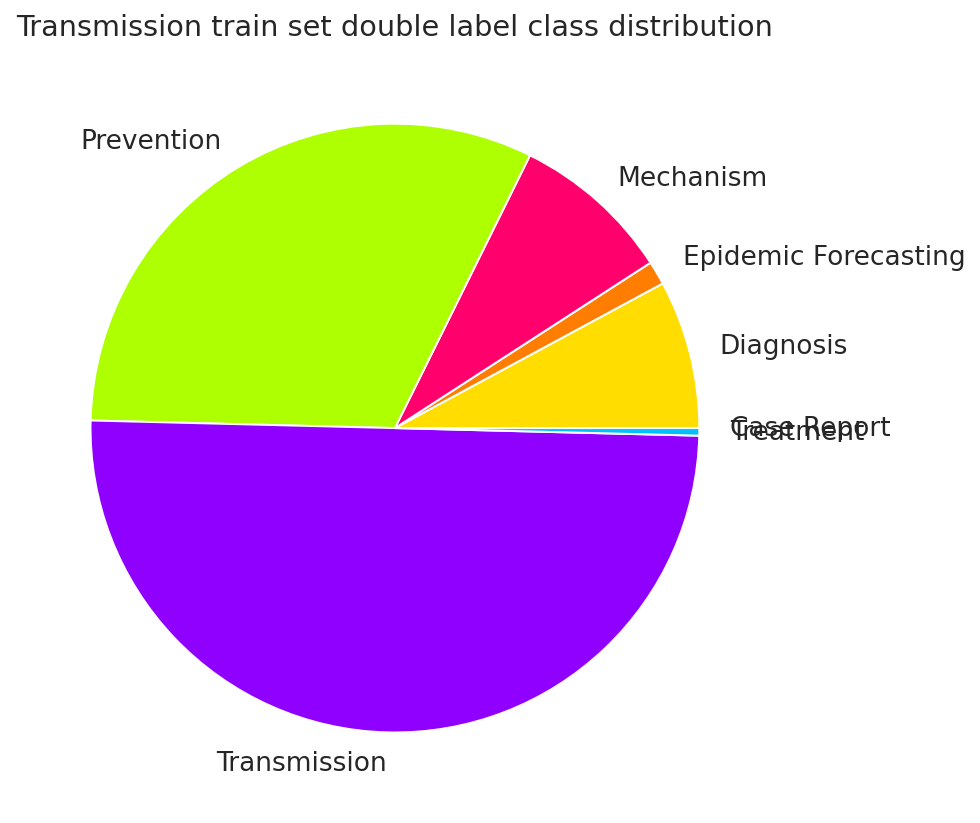

In [ ]:
keys = class_dict_true.keys()
values = class_dict_true.values()

# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(values, labels = keys)
plt.title("Transmission train set double label class distribution")
# show plot
plt.show()

#### Accuracy

In [ ]:
THRESHOLD = 0.5

In [ ]:
# calculating the accuracy of the model
accuracy(predictions, labels, threshold=THRESHOLD)

tensor(0.9526)

#### ROC for each tag

In [ ]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

AUROC per tag
Case Report: 0.9917894601821899
Diagnosis: 0.9743337631225586
Epidemic Forecasting: 0.9887785315513611
Mechanism: 0.9831726551055908
Prevention: 0.9782962799072266
Transmission: 0.9841275215148926
Treatment: 0.9726817607879639


#### classification report for each class

In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

                      precision    recall  f1-score   support

         Case Report     0.8929    0.9073    0.9000       248
           Diagnosis     0.8585    0.8564    0.8575       815
Epidemic Forecasting     0.8457    0.8253    0.8354       166
           Mechanism     0.8657    0.8856    0.8755       568
          Prevention     0.9396    0.8977    0.9182      1613
        Transmission     0.8177    0.8153    0.8165       352
           Treatment     0.8718    0.8791    0.8754      1075

           micro avg     0.8869    0.8772    0.8820      4837
           macro avg     0.8703    0.8667    0.8684      4837
        weighted avg     0.8877    0.8772    0.8823      4837
         samples avg     0.9041    0.9059    0.8904      4837



In [ ]:
THRESHOLD = [0.5, 0.55, 0.6, 0.65, 0.67, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for threshold in THRESHOLD:
  y_pred = predictions.numpy()
  y_true = labels.numpy()

  upper, lower = 1, 0

  y_pred = np.where(y_pred > threshold, upper, lower)

  print(f"Threshold: {threshold}")

  print(
      classification_report(
          y_true,
          y_pred,
          digits=4,
          target_names=LABEL_COLUMNS,
          zero_division=0
          )
      )

Threshold: 0.5
                      precision    recall  f1-score   support

         Case Report     0.8929    0.9073    0.9000       248
           Diagnosis     0.8585    0.8564    0.8575       815
Epidemic Forecasting     0.8457    0.8253    0.8354       166
           Mechanism     0.8657    0.8856    0.8755       568
          Prevention     0.9396    0.8977    0.9182      1613
        Transmission     0.8177    0.8153    0.8165       352
           Treatment     0.8718    0.8791    0.8754      1075

           micro avg     0.8869    0.8772    0.8820      4837
           macro avg     0.8703    0.8667    0.8684      4837
        weighted avg     0.8877    0.8772    0.8823      4837
         samples avg     0.9041    0.9059    0.8904      4837

Threshold: 0.55
                      precision    recall  f1-score   support

         Case Report     0.9032    0.9032    0.9032       248
           Diagnosis     0.8671    0.8405    0.8536       815
Epidemic Forecasting     0.8662    

In [ ]:
THRESHOLD = [threshold/100 for threshold in range(10, 100, 1)]
print(THRESHOLD)

[0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]


In [ ]:
Class_report = dict()

for threshold in THRESHOLD:
  y_pred = predictions.numpy()
  y_true = labels.numpy()

  upper, lower = 1, 0

  y_pred = np.where(y_pred > threshold, upper, lower)

  Class_report[f"THRESHOLD:{threshold}"] = classification_report(
      y_true,
      y_pred,
      target_names=LABEL_COLUMNS,
      zero_division=0,
      output_dict=True
  )

In [ ]:
micro_F1_Scores = [Class_report[key]["micro avg"]["f1-score"] for key in Class_report.keys()]
macro_F1_Scores = [Class_report[key]["macro avg"]["f1-score"] for key in Class_report.keys()]

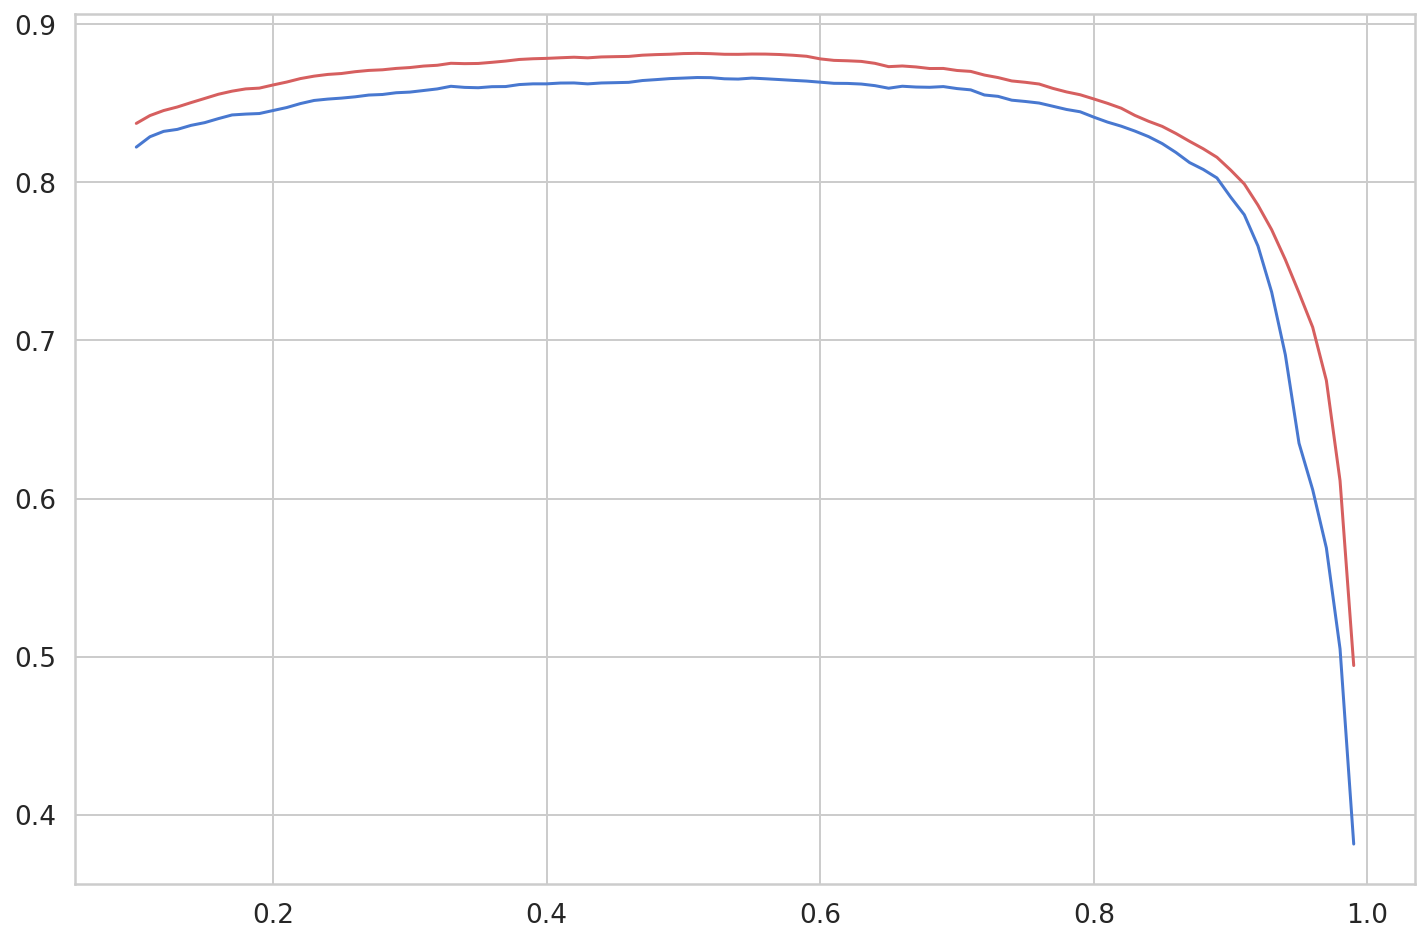

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

x = np.arange(10, 100, 1)/100
y1 = np.array(micro_F1_Scores)
y2 = np.array(macro_F1_Scores)

plt.plot(x, y1, 'r')  
plt.plot(x, y2, 'b') 
plt.show()

In [ ]:
max(micro_F1_Scores), np.argmax(micro_F1_Scores), x[41]

(0.8815789473684209, 41, 0.51)

In [ ]:
Annotation_size = {
    "Type_1": [],
    "Type_2": [],
    "Type_3": [],
    "Type_4g": []
}

In [ ]:
for index, annotation in enumerate(labels):

  annotation = annotation.numpy()
  count = np.count_nonzero(annotation)
  if count == 1:
    Annotation_size["Type_1"].append(index)
  elif count == 2:
    Annotation_size["Type_2"].append(index)
  elif count == 3:
    Annotation_size["Type_3"].append(index)
  else:
    Annotation_size["Type_4g"].append(index)

#### Classification Reports based on annotation counts

In [ ]:
# Annotation equals once

Type_1_predictions = predictions[Annotation_size["Type_1"]]
Type_1_labels = labels[Annotation_size["Type_1"]]

In [ ]:
y_pred = Type_1_predictions.numpy()
y_true = Type_1_labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print("classification report based on Annotation count equals one\n")

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

classification report based on Annotation count equals one

                      precision    recall  f1-score   support

         Case Report     0.9298    0.9073    0.9184       248
           Diagnosis     0.7711    0.9670    0.8580       303
Epidemic Forecasting     0.7324    0.9286    0.8189        56
           Mechanism     0.5044    0.9194    0.6514        62
          Prevention     0.9399    0.9556    0.9477      1194
        Transmission     0.4096    0.8095    0.5440        42
           Treatment     0.6881    0.9553    0.8000       291

           micro avg     0.8297    0.9472    0.8845      2196
           macro avg     0.7107    0.9204    0.7912      2196
        weighted avg     0.8543    0.9472    0.8931      2196
         samples avg     0.8808    0.9472    0.9026      2196



In [ ]:
# Annotation equals twice

Type_1_predictions = predictions[Annotation_size["Type_2"]]
Type_1_labels = labels[Annotation_size["Type_2"]]

In [ ]:
y_pred = Type_1_predictions.numpy()
y_true = Type_1_labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print("classification report based on Annotation count equals two\n")

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

classification report based on Annotation count equals two

                      precision    recall  f1-score   support

         Case Report     0.0000    0.0000    0.0000         0
           Diagnosis     0.9191    0.8217    0.8677       387
Epidemic Forecasting     0.9318    0.8283    0.8770        99
           Mechanism     0.9481    0.9035    0.9252       404
          Prevention     0.9384    0.8083    0.8685       339
        Transmission     0.9366    0.8421    0.8868       228
           Treatment     0.9818    0.8879    0.9325       669

           micro avg     0.9451    0.8584    0.8997      2126
           macro avg     0.8080    0.7274    0.7654      2126
        weighted avg     0.9499    0.8584    0.9016      2126
         samples avg     0.9404    0.8584    0.8836      2126



In [ ]:
# Annotation equals thrice

Type_1_predictions = predictions[Annotation_size["Type_3"]]
Type_1_labels = labels[Annotation_size["Type_3"]]

In [ ]:
y_pred = Type_1_predictions.numpy()
y_true = Type_1_labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print("classification report based on Annotation count equals three\n")

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

classification report based on Annotation count equals three

                      precision    recall  f1-score   support

         Case Report     0.0000    0.0000    0.0000         0
           Diagnosis     1.0000    0.7212    0.8380       104
Epidemic Forecasting     1.0000    0.2727    0.4286        11
           Mechanism     0.9714    0.8095    0.8831        84
          Prevention     0.9355    0.4462    0.6042        65
        Transmission     0.9643    0.7941    0.8710        68
           Treatment     0.9683    0.6289    0.7625        97

           micro avg     0.9732    0.6760    0.7978       429
           macro avg     0.8342    0.5246    0.6268       429
        weighted avg     0.9718    0.6760    0.7891       429
         samples avg     0.9761    0.6760    0.7825       429



In [ ]:
# Annotation equals more than 4

Type_1_predictions = predictions[Annotation_size["Type_4g"]]
Type_1_labels = labels[Annotation_size["Type_4g"]]

In [ ]:
y_pred = Type_1_predictions.numpy()
y_true = Type_1_labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print("classification report based on Annotation count equals more than 4\n")

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

classification report based on Annotation count equals more than 4

                      precision    recall  f1-score   support

         Case Report     0.0000    0.0000    0.0000         0
           Diagnosis     1.0000    0.5714    0.7273        21
Epidemic Forecasting     0.0000    0.0000    0.0000         0
           Mechanism     1.0000    0.7222    0.8387        18
          Prevention     1.0000    0.2667    0.4211        15
        Transmission     1.0000    0.5000    0.6667        14
           Treatment     1.0000    0.6667    0.8000        18

           micro avg     1.0000    0.5581    0.7164        86
           macro avg     0.7143    0.3896    0.4934        86
        weighted avg     1.0000    0.5581    0.7025        86
         samples avg     1.0000    0.5595    0.6877        86



#### model prediction and annotation segregation on baseline standards

In [ ]:
gold_predictions = pd.read_csv("drive/MyDrive/Biocreative/Biocreative/datasets/baseline/prediction_label_samples.csv")
gold_predictions = gold_predictions.reindex(columns=LABEL_COLUMNS)
# gold_predictions = gold_predictions.drop(["PMID"], axis=1)
gold_labels = pd.read_csv("drive/MyDrive/Biocreative/Biocreative/datasets/baseline/goldstandard_label_samples.csv")
gold_labels = gold_labels.reindex(columns=LABEL_COLUMNS)
# gold_labels = gold_labels.drop(["PMID"], axis=1)

In [ ]:
gold_predictions = gold_predictions.values.tolist()
gold_labels = gold_labels.values.tolist()

In [ ]:
Annotation_size = {
    "Type_1": [],
    "Type_2": [],
    "Type_3": [],
    "Type_4g": []
}

In [ ]:
for index, annotation in enumerate(gold_labels):

  annotation = np.array(annotation)
  count = np.count_nonzero(annotation)
  if count == 1:
    Annotation_size["Type_1"].append(index)
  elif count == 2:
    Annotation_size["Type_2"].append(index)
  elif count == 3:
    Annotation_size["Type_3"].append(index)
  else:
    Annotation_size["Type_4g"].append(index)

In [ ]:
gold_predictions = torch.tensor(gold_predictions)
gold_labels = torch.tensor(gold_labels)

In [ ]:
# Annotation equals once

Type_1_predictions = gold_predictions[Annotation_size["Type_1"]]
Type_1_labels = gold_labels[Annotation_size["Type_1"]]

In [ ]:
y_pred = Type_1_predictions.numpy()
y_true = Type_1_labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print("classification report based on Annotation count equals one\n")

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

classification report based on Annotation count equals one

                      precision    recall  f1-score   support

         Case Report     0.8636    0.7600    0.8085        50
           Diagnosis     0.0000    0.0000    0.0000         0
Epidemic Forecasting     0.9111    0.7593    0.8283        54
           Mechanism     0.7978    0.8161    0.8068        87
          Prevention     0.9475    0.9350    0.9412       908
        Transmission     0.6731    0.9211    0.7778        38
           Treatment     0.8398    0.8566    0.8481       251

           micro avg     0.8839    0.8999    0.8918      1388
           macro avg     0.7190    0.7211    0.7158      1388
        weighted avg     0.9067    0.8999    0.9023      1388
         samples avg     0.8542    0.8999    0.8694      1388



In [ ]:
# Annotation equals twice

Type_1_predictions = gold_predictions[Annotation_size["Type_2"]]
Type_1_labels = gold_labels[Annotation_size["Type_2"]]

In [ ]:
y_pred = Type_1_predictions.numpy()
y_true = Type_1_labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print("classification report based on Annotation count equals two\n")

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

classification report based on Annotation count equals two

                      precision    recall  f1-score   support

         Case Report     0.0000    0.0000    0.0000         0
           Diagnosis     0.9782    0.6793    0.8018       396
Epidemic Forecasting     0.9344    0.6129    0.7403        93
           Mechanism     0.9386    0.7880    0.8567       349
          Prevention     0.9029    0.8395    0.8700       299
        Transmission     0.9554    0.6772    0.7926       158
           Treatment     0.9967    0.8048    0.8905       743

           micro avg     0.9611    0.7640    0.8513      2038
           macro avg     0.8152    0.6288    0.7074      2038
        weighted avg     0.9633    0.7640    0.8500      2038
         samples avg     0.9342    0.7640    0.8179      2038



In [ ]:
# Annotation equals thrice

Type_1_predictions = gold_predictions[Annotation_size["Type_3"]]
Type_1_labels = gold_labels[Annotation_size["Type_3"]]

In [ ]:
y_pred = Type_1_predictions.numpy()
y_true = Type_1_labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print("classification report based on Annotation count equals three\n")

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

classification report based on Annotation count equals three

                      precision    recall  f1-score   support

         Case Report     0.0000    0.0000    0.0000         0
           Diagnosis     0.9722    0.4930    0.6542        71
Epidemic Forecasting     1.0000    0.4194    0.5909        31
           Mechanism     1.0000    0.7105    0.8308        76
          Prevention     0.9672    0.8551    0.9077        69
        Transmission     0.9815    0.6709    0.7970        79
           Treatment     0.9857    0.7841    0.8734        88

           micro avg     0.9826    0.6836    0.8063       414
           macro avg     0.8438    0.5618    0.6649       414
        weighted avg     0.9832    0.6836    0.7980       414
         samples avg     0.9674    0.6836    0.7820       414



In [ ]:
# Annotation equals more than 4

Type_1_predictions = gold_predictions[Annotation_size["Type_4g"]]
Type_1_labels = gold_labels[Annotation_size["Type_4g"]]

In [ ]:
y_pred = Type_1_predictions.numpy()
y_true = Type_1_labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print("classification report based on Annotation count equals more than 4\n")

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

classification report based on Annotation count equals more than 4

                      precision    recall  f1-score   support

         Case Report     0.0000    0.0000    0.0000         0
           Diagnosis     1.0000    0.4000    0.5714         5
Epidemic Forecasting     0.0000    0.0000    0.0000         0
           Mechanism     1.0000    0.5000    0.6667         6
          Prevention     1.0000    0.7500    0.8571         4
        Transmission     1.0000    0.5000    0.6667         4
           Treatment     1.0000    0.6000    0.7500         5

           micro avg     1.0000    0.5417    0.7027        24
           macro avg     0.7143    0.3929    0.5017        24
        weighted avg     1.0000    0.5417    0.6959        24
         samples avg     0.8333    0.5417    0.6429        24

